# Uncertainty wrapper Example

### Apply a classifier trained for the 20 newsgroups to the BBC news dataset

This script shows how to apply the uncertainty wrapper to enrich the predictions of a trained classifier with 
the corresponding uncertainty when applied to a new domain of application. The goal is to show how to use
a classifier already trained for one task in another task, and how we can measure that the blackbox adapts for the 
new task. We will see how wecan identify the cases where the blackbox is less confident on its predictions, 
and how we can increase the accuracy of the resulting system by rejecting those examples that more uncertain.

It first trains a naive bayes classifier over newsgroups that will be the blackbox in this example. 
Then, it uses it for predicting whether a new text is talking about politics or not, by grouping all the
newsgroups that are related to politics.
As the target application, it uses the dataset on BBC news(https://www.kaggle.com/yufengdev/bbc-fulltext-and-category),
making a binary classifier to predict if a news talks about politics or not.

In [3]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import sys
sys.path.append('..')
from uncwrap import UncertaintyWrapperEstimator
from uncwrap.tests.test_utils import PoliticsClassifierWrapper, load_politics_data

## Preparing the blackbox
First we load the 20 newsgroups dataset

In [4]:
newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')

X_train = newsgroups_train.data
X_test = newsgroups_test.data

y_train = newsgroups_train.target
y_test = newsgroups_test.target

We create a tf/idf vectorizer for texts. It is important to remark here that it will be the same that we use for computing the uncertainty, as we need to use the same representation for obtaining the predictions when calling the blackbox trained for newsgroups.

In [5]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf_vectorizer.fit(X_train)

TfidfVectorizer(max_features=1000)

We build a very simple naive bayes model using the 20 newsgroups data that will become the blackbox model.
Observe that in this case the results are categorical, which means that we cannot use the output probabilities as a measure of uncertainty.

In [6]:
blackbox_model = MultinomialNB()
blackbox_model.fit(tfidf_vectorizer.transform(X_train), y_train)

MultinomialNB()

We compute the accuracy of the 20 newsgroups dataset to check that the blackbox works

In [7]:
y_pred = blackbox_model.predict(tfidf_vectorizer.transform(X_test))
'accuracy of the black-box in test: {}'.format(accuracy_score(y_test, y_pred))

'accuracy of the black-box in test: 0.6565321295804567'

## Apply to the new problem
To apply the blackbox just created for the binary problem of predicting if a news talks about politics or not
we create a wrapper that returns 1 for those news that are related to politics and 0 otherwise.

In [8]:
politics_model = PoliticsClassifierWrapper(blackbox_model)
y_pred2 = politics_model.predict(tfidf_vectorizer.transform(X_test))
'accuracy of the black-box adapted to the politics use case in test: {}'.format(accuracy_score(y_test, y_pred))

'accuracy of the black-box adapted to the politics use case in test: 0.6565321295804567'

Load the BBC news dataset also making a transformation for getting 1 when the category is politics and 0 otherwise

In [9]:
polit_X_train, polit_X_test, polit_y_train, polit_y_test = load_politics_data("../tests/fixtures/bbc-text.csv")

We create the uncertaintywrapper referencing to the black box

In [10]:
uncertainty_wrapper = UncertaintyWrapperEstimator(black_box=politics_model)

And train the wrapper (mind that we are using the same vectorizer for the input as in the blackbox)

In [11]:
uncertainty_wrapper.fit(tfidf_vectorizer.transform(polit_X_train), polit_y_train)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


UncertaintyWrapperEstimator(black_box=PoliticsClassifierWrapper(black_box=MultinomialNB()))

Then we can obtain pairs of predictions and uncertainties

In [12]:
polit_y_pred_uncert = uncertainty_wrapper.predict(tfidf_vectorizer.transform(polit_X_test))

## Analyse the results

We compare the accuracy when removing the predictions that are more uncertain in the new problem

In [ ]:
polit_y_pred = polit_y_pred_uncert[:, 0]
polit_y_uncerts = polit_y_pred_uncert[:, 1]
print('accuracy of the black-box for politics: {}'.format(accuracy_score(polit_y_test, polit_y_pred)))

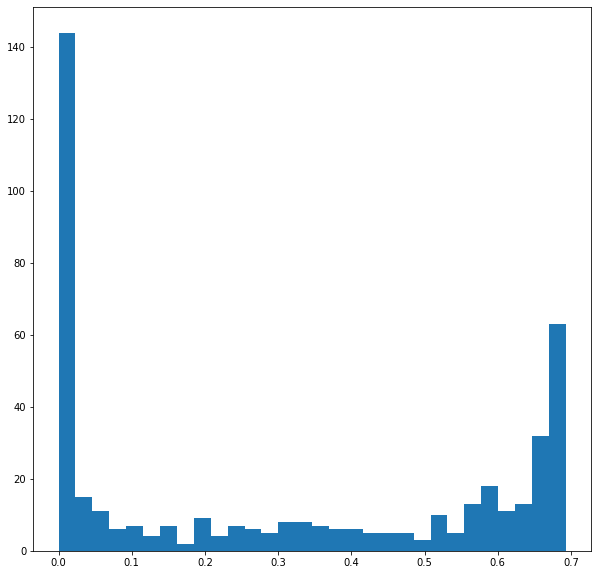

In [32]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.figure(figsize=(10,10))
plt.hist(polit_y_uncerts, bins=30, label='uncertainties');

In [31]:
UNCERTAINTY_THRESHOLD = 0.62
confident_texts = np.count_nonzero(polit_y_uncertain_preds_indexes)
total_texts = polit_y_uncerts.shape[0]
percentage = (confident_texts / total_texts)
accuracy = accuracy_score(np.array(polit_y_test)[polit_y_uncertain_preds_indexes],
                   polit_y_pred[polit_y_uncertain_preds_indexes])
polit_y_uncertain_preds_indexes = polit_y_uncerts < UNCERTAINTY_THRESHOLD
print('accuracy of the black-box for politics for keeping the more {} confident preds out of {}({:.1%}): {}'.format(
    confident_texts,
    total_texts,
    percentage,
    accuracy
    ))

accuracy of the black-box for politics for keeping the more 326 confident preds out of 445(73.3%): 0.8466257668711656


We can observe how the accuracy of the system when applied to the preserved data points has increased in almost 5 points.